In [15]:
import os
import sys
import glob
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import jax
import jax.numpy as jnp
# set 64-bit mode
jax.config.update("jax_enable_x64", True)


from scipy import signal, interpolate, stats
sys.path.append("/home/michael/Synology/Desktop/Data/Python/NeuralODE/DDFA_NODE/")
from ddfa_node import embed_data, takens_embedding, change_trial_length, split_data, get_aics, get_λs, phaser, stats as statistics, jax_utils

from tqdm.auto import tqdm
import torch

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.metrics import mean_squared_error
from scipy.signal import savgol_filter

import warnings
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:

data_loc = "data/Modelingandanalysis-latest/"
files = glob.glob(data_loc + "/**/*K0.csv", recursive=True)
df = pd.read_csv(files[0])
df["Subject"] = 0
for idx, file in enumerate(files[1:]):
    df1 = pd.read_csv(file)
    df1["Subject"] = idx + 1
    df = pd.concat((df, df1))
    
df = df[["hip_flexion_r", "hip_flexion_l", "knee_angle_r", "knee_angle_l", "ankle_angle_r", "ankle_angle_l", "Subject"]]
window_length = 30
polyorder = 5
feats = ["hip_flexion_l", "knee_angle_l", "ankle_angle_l", "hip_flexion_r",  "knee_angle_r", "ankle_angle_r"]
n_subjects = len(df["Subject"].unique())
total_steps = len(df)
data = np.zeros((n_subjects, total_steps // n_subjects, len(feats) * 2)) # 2x the features for velocity
for subject in range(n_subjects):
    data[subject, :, :len(feats)] = savgol_filter(df[df["Subject"] == subject][feats].to_numpy(), window_length=window_length, polyorder=polyorder, axis=0)
    data[subject, :, len(feats):] = savgol_filter(df[df["Subject"] == subject][feats].to_numpy(), window_length=window_length, polyorder=polyorder, axis=0, deriv=1)

# Standardize the data
data = (data - np.mean(data, axis=1)[:, None, :]) / np.std(data, axis=1)[:, None, :]


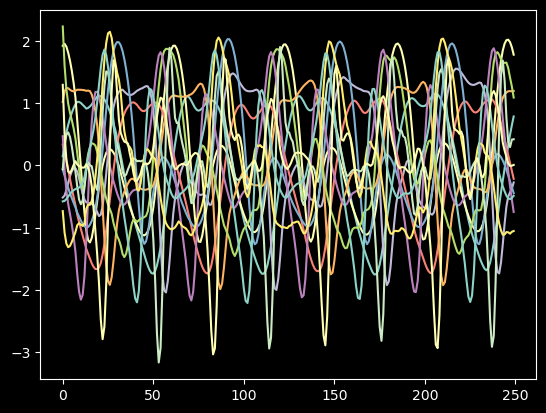

In [39]:
plt.plot(data[0, 0:500:2])

In [40]:
τ, k = 8, 6
data_tde = takens_embedding(data[:, ::2, :], τ, k)
# data_tde, τ, k = embed_data(data[:, ::2, :])

8
Data has been embedded using a delay of 8 timesteps and an embedding dimension of 6


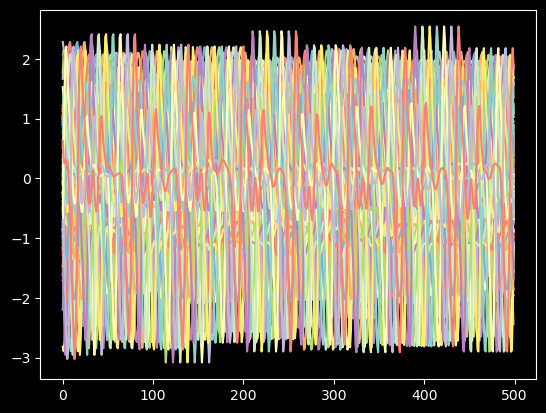

In [42]:
plt.plot(data_tde[2, 0:500])

In [43]:
print(f"The data have shape {data_tde.shape}")

The data have shape (12, 14232, 84)


(11232, 200, 84)
Step: 0, Loss: 0.8209433246737317, Computation time: 6.978423118591309


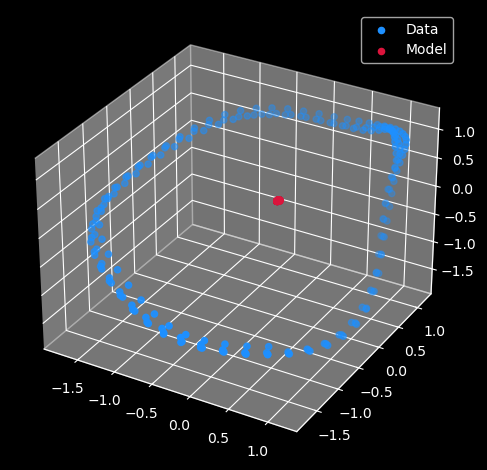

Step: 1000, Loss: 0.361716318012393, Computation time: 192.8667459487915


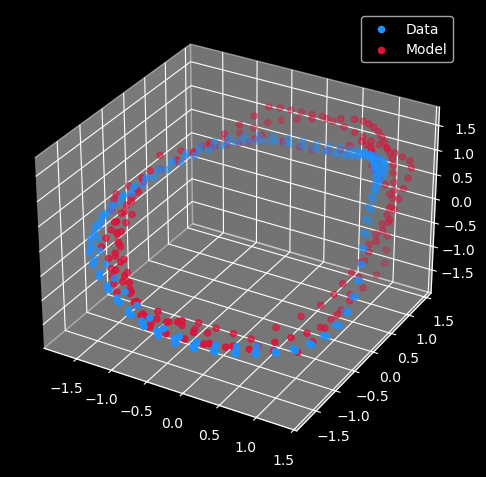

In [44]:
# , static_argnames=["timesteps_per_trial", "skip", "t1", "width_size", "hidden_size", "ode_size", "depth", "batch_size", "seed", "print_every", "length_strategy", "lr_strategy", "seeding_strategy", "steps_strategy", "plot","k"
ts, ys, model = jax_utils.train_NODE(
    # model=model,
    data_tde[:, :, :],
    timesteps_per_trial=200,
    t1=2.0,
    width_size=128,
    hidden_size=256,
    ode_size=8,
    depth=3,
    batch_size=128,
    seed=69,
    lr_strategy=(1e-3,),
    steps_strategy=(70000, 30000, 25000),
    length_strategy=(1,),
    skip_strategy=(15,),
    seeding_strategy=(1/2,),
    plot=True,
    print_every=1000,
    k=1,
    use_stabilized_node=False,
    linear=False,
    plot_fn=None,
    # k=max_power+2
)

In [13]:
from ddfa_node.floquet import get_phased_signals
import seaborn as sb
from sklearn.metrics import r2_score
from tqdm.auto import tqdm

def validate_self_gen_data(X_true, X_gen, T=50, N=101):
    trials, _, feats = X_true.shape

    r2s = np.zeros((trials, feats))
    for trial in tqdm(range(trials)):
        all_sigs_true, _ = get_phased_signals(X_true[trial].T, nSegments=N, distance=T)
        mean_sigs_true = all_sigs_true.mean(axis=0)
    
        all_sigs_gen, _ = get_phased_signals(X_gen[trial].T, nSegments=N, distance=T)
        mean_sigs_gen = all_sigs_gen.mean(axis=0)
        for feat in range(feats):
            r2s[trial, feat] = np.max([r2_score(mean_sigs_true[feat], np.roll(mean_sigs_gen[feat], shift)) for shift in range(-N, N, 1)])
    return r2s

In [27]:
new_ts = jnp.linspace(0, 10, 10000)
seeding_steps = 100
out = jax.vmap(model, in_axes=(None, 0))(new_ts, data_tde[:, :seeding_steps, :])

In [28]:
out.shape

(12, 10000, 84)

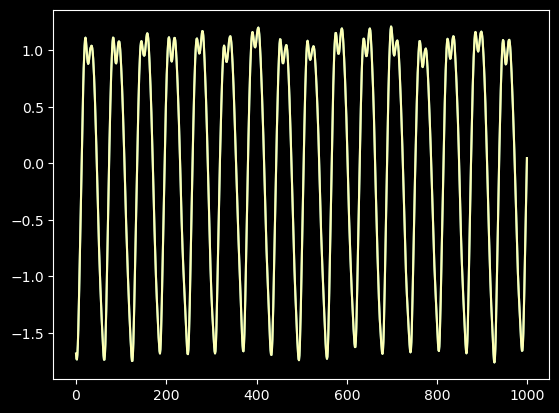

In [35]:
plt.plot(data_tde[1, :1000, 0])
plt.plot(data_tde[2, :1000, 0])

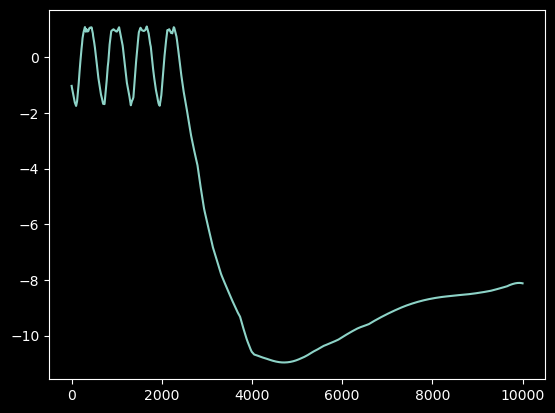

In [31]:
plt.plot(out[2, :, 1])

In [18]:
r2s = validate_self_gen_data(data[:, ::2], out[:, -2500:, :])
ax = sb.heatmap(r2s) #, vmin=0, vmax=1)
plt.ylabel("Trial")
plt.yticks(range(0, 100, 5), range(0, 100, 5))
plt.xlabel("Feature")
# plt.xticks(range(0, 12, 2), range(0, 12, 2))
ax.collections[0].colorbar.set_label("$R^2$")

  0%|          | 0/12 [00:00<?, ?it/s]

/home/michael/Synology/Desktop/Data/Python/NeuralODE/DDFA_NODE/ddfa_node/phaser.py:404: UserWarning: PhaserForSample:nCycMismatch
  warnings.warn( "PhaserForSample:nCycMismatch" )
/home/michael/Synology/Desktop/Data/Python/NeuralODE/DDFA_NODE/ddfa_node/phaser.py:402: UserWarning: PhaserForSample:tooShort
  warnings.warn( "PhaserForSample:tooShort" )


Exception: ('newPhaser:emptySection', 'Poincare section is empty -- bailing out')